# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [2]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.joe,
#    parameters=np.array([[2.5]]), rotation=90
#    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

rho_t =0.7
nu_t = 4.0
copula_pv = pv.Bicop(
    family=pv.BicopFamily.student,
    parameters=np.array([[rho_t],
                          [nu_t]]),
    rotation=0
)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [4]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_3225602/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3225602/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3225602/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [5]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None
        )
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-18 18:33:35,334] A new study created in RDB with name: no-name-4a6e6038-f953-4aa5-8a59-afe059a4c157
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 3/2000 [00:00<03:30,  9.50it/s]

current_loss: tensor(1.4441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4534190893173218
current_loss: tensor(1.4392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4348547458648682
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4295974969863892


  0%|          | 6/2000 [00:00<02:15, 14.68it/s]

current_loss: tensor(1.4059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.427940011024475
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.427937388420105
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4279756546020508
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4280835390090942
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:32, 13.04it/s]


current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4282033443450928
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.428269863128662
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4285019636154175
Early Stop at iteration 9 with minimal loss tensor(1.4279, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4052, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:40,  9.07it/s]

current_loss: tensor(1.3661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3843411207199097
current_loss: tensor(1.3661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3048559427261353
current_loss: tensor(1.3036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3283, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.10it/s]

current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2918723821640015
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2873276472091675
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:25,  9.72it/s]

current_loss_val:  1.2832567691802979
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2794756889343262
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:16, 10.14it/s]

current_loss_val:  1.2746490240097046


  0%|          | 9/2000 [00:00<03:11, 10.39it/s]

current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738062143325806
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731716632843018
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:09, 10.51it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711360454559326
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723714113235474
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:07, 10.58it/s]

current_loss_val:  1.271032691001892
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710235118865967
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27156400680542


  1%|          | 15/2000 [00:01<03:06, 10.65it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713910341262817
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717238664627075
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:21,  9.83it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721019983291626
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272733449935913
Early Stop at iteration 17 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:40,383] Trial 0 finished with value: -2.5420467853546143 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.353822249678537, 'penalty_decorrelation_ridge_second_difference': 8.145686033019858}. Best is trial 0 with value: -2.5420467853546143.
  0%|          | 1/2000 [00:00<04:38,  7.17it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271689772605896
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.47it/s]

current_loss_val:  1.2714518308639526
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710936069488525
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713052034378052


  0%|          | 5/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272168517112732
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721657752990723
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:44,  8.88it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272308111190796
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723337411880493
Early Stop at iteration 7 with minimal loss tensor(1.2711, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:41,747] Trial 1 finished with value: -2.542186975479126 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.887750004042488, 'penalty_decorrelation_ridge_second_difference': 3.5417289151149918}. Best is trial 0 with value: -2.5420467853546143.
  0%|          | 1/2000 [00:00<04:27,  7.49it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712912559509277
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712126970291138


  0%|          | 3/2000 [00:00<03:29,  9.52it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270880937576294
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:25,  9.71it/s]

current_loss_val:  1.2706722021102905
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270685076713562
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270654559135437


  0%|          | 8/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710225582122803
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708953619003296
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:12, 10.33it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708781957626343
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270934820175171
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:40,  9.04it/s]


current_loss_val:  1.2709959745407104
Early Stop at iteration 10 with minimal loss tensor(1.2707, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:33:43,421] Trial 2 finished with value: -2.541309118270874 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.8687080626709682, 'penalty_decorrelation_ridge_second_difference': 17.86599351600584}. Best is trial 2 with value: -2.541309118270874.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714077234268188
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271297574043274


  0%|          | 3/2000 [00:00<03:28,  9.56it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708383798599243
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708430290222168
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710490226745605
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720613479614258
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:44,  8.89it/s]

current_loss_val:  1.271423101425171
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714482545852661
Early Stop at iteration 7 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:44,809] Trial 3 finished with value: -2.5416767597198486 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.012884648261096, 'penalty_decorrelation_ridge_second_difference': 6.362060624415086}. Best is trial 2 with value: -2.541309118270874.
  0%|          | 1/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715727090835571
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714104652404785


  0%|          | 3/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710354328155518
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271182894706726
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:16, 10.18it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720723152160645
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718632221221924
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:53,  8.52it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271905541419983
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721375226974487
Early Stop at iteration 7 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:46,228] Trial 4 finished with value: -2.5420711040496826 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.70557422236726, 'penalty_decorrelation_ridge_second_difference': 2.724747880591843}. Best is trial 2 with value: -2.541309118270874.
  0%|          | 1/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715994119644165
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713375091552734


  0%|          | 3/2000 [00:00<03:28,  9.59it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711073160171509
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27096426486969
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710741758346558
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713760137557983
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:39,  9.06it/s]

current_loss_val:  1.2713053226470947
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714323997497559
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713872194290161
Early Stop at iteration 8 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:47,675] Trial 5 finished with value: -2.54192852973938 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.122558859293786, 'penalty_decorrelation_ridge_second_difference': 10.931903194315584}. Best is trial 2 with value: -2.541309118270874.
  0%|          | 1/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712870836257935
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712117433547974


  0%|          | 4/2000 [00:00<03:43,  8.94it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270825743675232
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270653247833252


  0%|          | 6/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706719636917114
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706173658370972
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.19it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708425521850586
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708848714828491
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:38,  9.12it/s]

current_loss_val:  1.2709168195724487
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710081338882446
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710078954696655
Early Stop at iteration 10 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:49,344] Trial 6 finished with value: -2.5412344932556152 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.698759283687718, 'penalty_decorrelation_ridge_second_difference': 16.158595506300692}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713983058929443
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712572813034058


  0%|          | 4/2000 [00:00<03:44,  8.89it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709732055664062
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270715594291687


  0%|          | 6/2000 [00:00<03:23,  9.78it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707602977752686
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710411548614502
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.17it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712202072143555
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712327241897583
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:47,  8.76it/s]


current_loss_val:  1.2712303400039673
Early Stop at iteration 8 with minimal loss tensor(1.2707, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:33:50,863] Trial 7 finished with value: -2.5414316654205322 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.216342057861675, 'penalty_decorrelation_ridge_second_difference': 14.758947411514113}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<04:40,  7.14it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271716833114624
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:36,  9.22it/s]

current_loss_val:  1.2714272737503052
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710922956466675
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712026834487915


  0%|          | 6/2000 [00:00<03:36,  9.20it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271859884262085
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718414068222046


  0%|          | 7/2000 [00:00<03:59,  8.33it/s]


current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720694541931152
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272359848022461
Early Stop at iteration 7 with minimal loss tensor(1.2711, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:33:52,429] Trial 8 finished with value: -2.542184591293335 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.581096720817225, 'penalty_decorrelation_ridge_second_difference': 5.659765953752661}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<04:34,  7.29it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712886333465576
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712117433547974


  0%|          | 3/2000 [00:00<03:30,  9.47it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270833969116211
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2706530094146729
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706729173660278
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706172466278076


  0%|          | 8/2000 [00:00<03:18, 10.05it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708065509796143
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708994150161743
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:14, 10.24it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709861993789673
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271155595779419
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:42,  8.95it/s]


current_loss_val:  1.2711811065673828
Early Stop at iteration 10 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:33:54,147] Trial 9 finished with value: -2.5412344932556152 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.2223215719585476, 'penalty_decorrelation_ridge_second_difference': 16.368451534932564}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271264910697937
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.46it/s]

current_loss_val:  1.271222472190857
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27074134349823
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:38,  9.12it/s]

current_loss_val:  1.2708408832550049
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270858645439148
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270691156387329


  0%|          | 7/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708535194396973
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270960807800293
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709985971450806
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710446119308472
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:44,  8.88it/s]


current_loss_val:  1.2710810899734497
Early Stop at iteration 10 with minimal loss tensor(1.2707, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:33:55,910] Trial 10 finished with value: -2.541382074356079 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.63263720714517, 'penalty_decorrelation_ridge_second_difference': 22.883172934896933}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<05:33,  5.99it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713054418563843
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712256908416748
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270798683166504


  0%|          | 4/2000 [00:00<04:13,  7.88it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707412242889404
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707628011703491


  0%|          | 6/2000 [00:00<03:41,  9.01it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270764946937561
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707608938217163
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:15,  7.81it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270807147026062
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708665132522583
Early Stop at iteration 8 with minimal loss tensor(1.2707, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:33:57,631] Trial 11 finished with value: -2.541482448577881 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.145998977184936, 'penalty_decorrelation_ridge_second_difference': 19.228731839122585}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<05:49,  5.72it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713264226913452
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:43,  5.81it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710318565368652
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:20,  7.66it/s]

current_loss_val:  1.270758867263794
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708196640014648
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271094799041748


  0%|          | 6/2000 [00:00<03:59,  8.34it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715240716934204
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271506667137146


  0%|          | 7/2000 [00:00<04:39,  7.14it/s]


current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715849876403809
Early Stop at iteration 7 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:33:59,432] Trial 12 finished with value: -2.541517496109009 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.42876258670397, 'penalty_decorrelation_ridge_second_difference': 2.954095877290517}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<05:32,  6.01it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712851762771606
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:32,  6.01it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709275484085083
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:54,  6.78it/s]

current_loss_val:  1.2706822156906128
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710931301116943
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:42,  7.05it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708977460861206
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709697484970093
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:52,  6.81it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712920904159546
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271422266960144
Early Stop at iteration 7 with minimal loss tensor(1.2707, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:01,201] Trial 13 finished with value: -2.5413641929626465 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.905100335819224, 'penalty_decorrelation_ridge_second_difference': 0.36232061406480776}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<05:33,  6.00it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712936401367188
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:29,  7.42it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712173461914062
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270842432975769


  0%|          | 4/2000 [00:00<04:45,  7.00it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706552743911743
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:54,  8.51it/s]

current_loss_val:  1.2706838846206665
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270743727684021
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270776391029358


  0%|          | 8/2000 [00:01<04:22,  7.58it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709729671478271
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710227966308594
Early Stop at iteration 8 with minimal loss tensor(1.2707, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:02,949] Trial 14 finished with value: -2.5413103103637695 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.586762524822412, 'penalty_decorrelation_ridge_second_difference': 19.018878505209916}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<05:57,  5.59it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712525129318237
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:47,  6.95it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712693214416504
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709206342697144


  0%|          | 4/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709156274795532
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708989381790161
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:44,  8.87it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709965705871582
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271188497543335
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:39,  9.07it/s]

current_loss_val:  1.2713699340820312
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271475911140442
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:17,  7.74it/s]


current_loss_val:  1.2716445922851562
Early Stop at iteration 9 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:04,826] Trial 15 finished with value: -2.5417978763580322 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.812642000964626, 'penalty_decorrelation_ridge_second_difference': 27.654492034884584}. Best is trial 6 with value: -2.5412344932556152.
  0%|          | 1/2000 [00:00<05:31,  6.03it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271255373954773
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:33,  5.99it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710078954696655
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:52,  6.82it/s]

current_loss_val:  1.2707587480545044
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709623575210571
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:11,  7.93it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705861330032349
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705906629562378
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<03:39,  9.07it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710022926330566
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707765102386475
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:30,  7.35it/s]

current_loss_val:  1.270798921585083
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708039283752441
Early Stop at iteration 9 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:06,814] Trial 16 finished with value: -2.5411720275878906 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6356943140057172, 'penalty_decorrelation_ridge_second_difference': 6.0141557393923435}. Best is trial 16 with value: -2.5411720275878906.
  0%|          | 1/2000 [00:00<05:36,  5.93it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712525129318237
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:29,  6.07it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271111011505127
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:25,  7.53it/s]

current_loss_val:  1.2708005905151367
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715383768081665
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:44,  8.89it/s]

current_loss_val:  1.2707056999206543
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708247900009155
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:47,  6.92it/s]

current_loss_val:  1.2708560228347778
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706496715545654
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:33,  7.28it/s]

current_loss_val:  1.2707710266113281
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705278396606445
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:54,  8.48it/s]

current_loss_val:  1.2702598571777344
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699693441390991
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269981861114502


  1%|          | 14/2000 [00:01<03:37,  9.15it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690356969833374
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:30,  9.40it/s]

current_loss_val:  1.2686339616775513
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679349184036255
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670924663543701
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266786813735962
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:40,  9.00it/s]

current_loss_val:  1.2669180631637573
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667326927185059
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659269571304321


  1%|          | 22/2000 [00:02<03:27,  9.52it/s]

current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658611536026
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654838562011719
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:31,  9.32it/s]

current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265365481376648
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654328346252441
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:22,  9.74it/s]

current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652491331100464
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646210193634033
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:17,  9.97it/s]

current_loss_val:  1.2641358375549316
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263803243637085
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:20,  9.79it/s]

current_loss_val:  1.2631367444992065
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263105869293213
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629766464233398


  2%|▏         | 33/2000 [00:03<03:32,  9.24it/s]

current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627108097076416
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:23,  9.66it/s]

current_loss_val:  1.2626968622207642
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625190019607544
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:47,  8.64it/s]

current_loss_val:  1.2626581192016602
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626333236694336
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:43,  8.79it/s]

current_loss_val:  1.262498140335083
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626084089279175
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:56,  8.28it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262575626373291
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627581357955933
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:52,  8.44it/s]

current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626430988311768
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627947330474854
Early Stop at iteration 42 with minimal loss tensor(1.2625, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:12,474] Trial 17 finished with value: -2.524996042251587 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.47625785692790273, 'penalty_decorrelation_ridge_second_difference': 4.340148322544837}. Best is trial 17 with value: -2.524996042251587.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<15:01,  2.22it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271252155303955
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<14:32,  2.29it/s]

current_loss_val:  1.2711225748062134
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<12:37,  2.64it/s]

current_loss_val:  1.2707946300506592
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<16:18,  2.04it/s]

current_loss_val:  1.271198034286499
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:28,  3.51it/s]

current_loss_val:  1.27114737033844
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271013617515564
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709513902664185


  0%|          | 8/2000 [00:02<08:06,  4.09it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270706295967102
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<05:58,  5.55it/s]

current_loss_val:  1.2707053422927856
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270667314529419
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<05:16,  6.27it/s]

current_loss_val:  1.2708238363265991
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705967426300049
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<04:36,  7.18it/s]

current_loss_val:  1.269319772720337
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269139289855957
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<04:04,  8.13it/s]

current_loss_val:  1.2686748504638672
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267376184463501
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<03:43,  8.88it/s]

current_loss_val:  1.267072081565857
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670015096664429
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665457725524902


  1%|          | 21/2000 [00:04<03:32,  9.33it/s]

current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662495374679565
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662874460220337
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<03:26,  9.58it/s]

current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266352891921997
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663025856018066
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:04<03:37,  9.10it/s]

current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660483121871948
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660295963287354
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<03:38,  9.04it/s]

current_loss_val:  1.2657899856567383
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659258842468262
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<03:39,  8.97it/s]

current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265778660774231
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264307975769043
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:05<03:25,  9.57it/s]

current_loss_val:  1.2642548084259033
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642728090286255
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644529342651367


  2%|▏         | 33/2000 [00:05<03:19,  9.87it/s]

current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640894651412964
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264111876487732
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<03:15, 10.08it/s]

current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641326189041138
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264095664024353
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<03:24,  9.61it/s]

current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263885736465454
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638722658157349
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<03:17,  9.92it/s]

current_loss_val:  1.2638312578201294
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637507915496826
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:06<03:20,  9.78it/s]

current_loss_val:  1.263809323310852
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636430263519287
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633841037750244


  2%|▏         | 45/2000 [00:06<03:25,  9.52it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630242109298706
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628142833709717


  2%|▏         | 47/2000 [00:06<03:18,  9.83it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628138065338135
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627686262130737
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:06<03:19,  9.77it/s]

current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628912925720215
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626535892486572
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:07<03:14, 10.03it/s]

current_loss_val:  1.2624515295028687
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26240873336792
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623714208602905


  3%|▎         | 53/2000 [00:07<03:08, 10.31it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262054204940796
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619980573654175
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:07<03:09, 10.26it/s]

current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619407176971436
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618587017059326
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:07<03:19,  9.76it/s]

current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619318962097168
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618391513824463
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:08<03:11, 10.15it/s]

current_loss_val:  1.2616409063339233
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612138986587524
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26126229763031


  3%|▎         | 63/2000 [00:08<03:08, 10.29it/s]

current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613145112991333
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613284587860107
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:08<03:07, 10.31it/s]

current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611626386642456
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261238932609558
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:08<03:06, 10.34it/s]

current_loss_val:  1.2611795663833618
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610574960708618
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610188722610474


  3%|▎         | 69/2000 [00:08<03:06, 10.37it/s]

current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611474990844727
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611132860183716
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:09<03:05, 10.38it/s]

current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610938549041748
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610996961593628
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:09<04:08,  7.76it/s]

current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611582279205322
Early Stop at iteration 72 with minimal loss tensor(1.2610, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:22,364] Trial 18 finished with value: -2.5220375061035156 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7902670179962461, 'penalty_decorrelation_ridge_second_difference': 2.3883355505148423}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:32,  6.02it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713024616241455
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.39it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271233320236206
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707719802856445


  0%|          | 4/2000 [00:00<04:18,  7.72it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708899974822998
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704877853393555


  0%|          | 6/2000 [00:00<03:43,  8.91it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705276012420654
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707738876342773
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:30,  9.48it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707430124282837
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710843086242676
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:06,  8.07it/s]


current_loss_val:  1.2708725929260254
Early Stop at iteration 9 with minimal loss tensor(1.2705, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:24,118] Trial 19 finished with value: -2.540975570678711 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.454851017955628, 'penalty_decorrelation_ridge_second_difference': 9.040264003909861}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:28,  6.09it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712464332580566
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:31,  6.03it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711009979248047
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:27,  7.47it/s]

current_loss_val:  1.2706314325332642
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714074850082397
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:03,  8.19it/s]

current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709318399429321
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708547115325928
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:29,  9.48it/s]

current_loss_val:  1.2708449363708496
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701678276062012
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703081369400024


  1%|          | 11/2000 [00:01<03:19,  9.95it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270417332649231
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703540325164795
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:02,  8.19it/s]


current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704488039016724
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704716920852661
Early Stop at iteration 12 with minimal loss tensor(1.2702, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:26,185] Trial 20 finished with value: -2.540335178375244 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.3843892938844484, 'penalty_decorrelation_ridge_second_difference': 1.893824783547831}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<04:32,  7.34it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712461948394775
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:57,  8.40it/s]

current_loss_val:  1.2710405588150024
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705786228179932
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:49,  8.68it/s]

current_loss_val:  1.2711139917373657
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710412740707397
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709476947784424


  0%|          | 7/2000 [00:00<03:28,  9.57it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271039605140686
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:21,  7.64it/s]


current_loss_val:  1.270725131034851
Early Stop at iteration 7 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:27,713] Trial 21 finished with value: -2.5411572456359863 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.6544424636394828, 'penalty_decorrelation_ridge_second_difference': 1.3315544742659355}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712470293045044
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710126638412476
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:30,  7.37it/s]

current_loss_val:  1.2706001996994019
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722265720367432
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:46,  8.80it/s]

current_loss_val:  1.2711248397827148
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711045742034912
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271022081375122


  0%|          | 7/2000 [00:00<04:34,  7.26it/s]


current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270677089691162
Early Stop at iteration 7 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:29,300] Trial 22 finished with value: -2.5412001609802246 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.097731893721248, 'penalty_decorrelation_ridge_second_difference': 1.2563469000782366}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:33,  5.99it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712639570236206
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:36,  5.94it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710601091384888
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:02,  6.61it/s]

current_loss_val:  1.2707847356796265
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270936369895935
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:01,  8.26it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270492434501648
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705515623092651
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:40,  9.04it/s]

current_loss_val:  1.2706624269485474
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706382274627686
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708768844604492


  0%|          | 9/2000 [00:01<04:31,  7.33it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706249952316284
Early Stop at iteration 9 with minimal loss tensor(1.2705, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:31,152] Trial 23 finished with value: -2.540984630584717 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4068173078436521, 'penalty_decorrelation_ridge_second_difference': 8.397081874133992}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712630033493042
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:41,  4.97it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271574854850769
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:44,  7.01it/s]

current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724103927612305
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710561752319336
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:53,  8.54it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271130084991455
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713403701782227
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:35,  7.24it/s]

current_loss_val:  1.2712322473526
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271268367767334
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712591886520386
Early Stop at iteration 8 with minimal loss tensor(1.2711, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:33,073] Trial 24 finished with value: -2.542112350463867 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.49434553807516907, 'penalty_decorrelation_ridge_second_difference': 0.16559365662824188}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:30,  6.06it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713147401809692
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.37it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271243691444397
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707642316818237


  0%|          | 4/2000 [00:00<04:15,  7.82it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708584070205688
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705003023147583


  0%|          | 6/2000 [00:00<03:40,  9.03it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705721855163574
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708909511566162
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709518671035767
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715449333190918
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 9/2000 [00:01<04:06,  8.07it/s]


tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712517976760864
Early Stop at iteration 9 with minimal loss tensor(1.2705, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:34,790] Trial 25 finished with value: -2.5410006046295166 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.503178722007098, 'penalty_decorrelation_ridge_second_difference': 7.69758591960153}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:24,  6.15it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712745666503906
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:34,  7.29it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271226167678833
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707297801971436


  0%|          | 4/2000 [00:00<04:22,  7.61it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708781957626343
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704192399978638


  0%|          | 7/2000 [00:00<03:38,  9.13it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705020904541016
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706729173660278
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:23,  9.80it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706843614578247
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705940008163452
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:08,  8.01it/s]


current_loss_val:  1.270919919013977
Early Stop at iteration 9 with minimal loss tensor(1.2704, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-18 18:34:36,569] Trial 26 finished with value: -2.5408384799957275 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.858928614559188, 'penalty_decorrelation_ridge_second_difference': 6.847162235543618}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<04:32,  7.33it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271252989768982
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:55,  8.50it/s]

current_loss_val:  1.2709596157073975
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705955505371094
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707728147506714


  0%|          | 5/2000 [00:00<03:48,  8.74it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710866928100586
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:12,  7.91it/s]

current_loss_val:  1.270984411239624
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708746194839478
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271216869354248
Early Stop at iteration 7 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:38,069] Trial 27 finished with value: -2.5411906242370605 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.121692031591333, 'penalty_decorrelation_ridge_second_difference': 1.4646146441479002}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:31,  6.03it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271261215209961
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709219455718994
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:32,  7.32it/s]

current_loss_val:  1.270755410194397
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706692218780518
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:05,  8.11it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704790830612183
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270533561706543
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<03:37,  9.15it/s]

current_loss_val:  1.2708271741867065
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270922303199768
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:33,  7.28it/s]

current_loss_val:  1.2713141441345215
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712790966033936
Early Stop at iteration 9 with minimal loss tensor(1.2705, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:39,932] Trial 28 finished with value: -2.5409579277038574 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8123314052432895, 'penalty_decorrelation_ridge_second_difference': 7.431873217218746}. Best is trial 18 with value: -2.5220375061035156.
  0%|          | 1/2000 [00:00<05:35,  5.96it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713041305541992
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712347507476807
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707698345184326


  0%|          | 4/2000 [00:00<04:18,  7.73it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708872556686401
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270486831665039
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:37,  9.17it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705293893814087
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707812786102295
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:06,  8.07it/s]

current_loss_val:  1.2707664966583252
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711800336837769
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709413766860962
Early Stop at iteration 9 with minimal loss tensor(1.2705, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-18 18:34:41,768] Trial 29 finished with value: -2.540973663330078 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.793376747011031, 'penalty_decorrelation_ridge_second_difference': 8.793808655418518}. Best is trial 18 with value: -2.5220375061035156.


hyperparameter_tuning done


In [8]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:47, 21.11it/s]

current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:39, 24.92it/s]

current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:39, 25.26it/s]

current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4046, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:40, 24.31it/s]

current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:39, 24.83it/s]

current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:37, 26.20it/s]

current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:37, 26.06it/s]

current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:39, 24.93it/s]

current_loss: tensor(1.4034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:38, 25.23it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:39, 24.46it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:40, 23.92it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:38, 25.33it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:37, 25.46it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:37, 25.59it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:34, 27.41it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:01<00:33, 27.92it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:37, 25.38it/s]

current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:02<00:34, 27.21it/s]

current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:02<00:35, 26.51it/s]

current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 66/1000 [00:02<01:02, 14.91it/s]

current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 68/1000 [00:03<00:44, 20.84it/s]

current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 68 with minimal loss tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [9]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3840675354003906
current_loss: tensor(1.3614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:35, 10.45it/s]

current_loss_val:  1.2824954986572266
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281751275062561
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:43,  9.59it/s]

current_loss_val:  1.279618501663208
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711087465286255
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:46,  9.35it/s]

current_loss_val:  1.2714128494262695
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703732252120972


  1%|          | 8/1000 [00:00<01:40,  9.84it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702016830444336
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688311338424683
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<01:37, 10.12it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683480978012085
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26845121383667
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:35, 10.31it/s]

current_loss_val:  1.2695071697235107
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270495057106018
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:34, 10.43it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269679307937622
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:57,  8.40it/s]

current_loss_val:  1.2693594694137573
Early Stop at iteration 14 with minimal loss tensor(1.2683, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [22]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6,
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =2.0,
                tau_vi_sigma_init = 0.15,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 5/800 [00:14<37:20,  2.82s/it]

[convergence] ELBO/obs=-7.490614  smoothed=-7.241716  tol=0.01

Iteration [5/800] train=7.4906    S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.60
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.069614  τ₁≈3.4186  τ₂≈5.7036  |  (EB targets) τ₄*≈0.54318  τ₁*≈114.24  τ₂*≈163.35
E_qf_total≈36.8137  E_qf1≈0.3370  E_qf2≈0.3032
[monitor] τ₄·E_qf≈2.56  target≈20.00 | τ₁·E_qf1≈1.15  target≈38.50 | τ₂·E_qf2≈1.73  target≈49.53
 [ELBO] per-obs=-7.490614


  1%|▏         | 10/800 [00:28<36:53,  2.80s/it]

[convergence] ELBO/obs=-8.185401  smoothed=-7.525337  tol=0.01

Iteration [10/800] train=8.1854    S_train=4 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.73
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.035394  τ₁≈3.4123  τ₂≈5.4437  |  (EB targets) τ₄*≈0.54776  τ₁*≈113.33  τ₂*≈163.13
E_qf_total≈36.5058  E_qf1≈0.3429  E_qf2≈0.3039
[monitor] τ₄·E_qf≈1.29  target≈20.00 | τ₁·E_qf1≈1.17  target≈38.87 | τ₂·E_qf2≈1.65  target≈49.57
 [ELBO] per-obs=-8.185401


  2%|▏         | 15/800 [00:42<36:36,  2.80s/it]

[convergence] ELBO/obs=-9.032840  smoothed=-8.006244  tol=0.01

Iteration [15/800] train=9.0328    S_train=4 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.85
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.025104  τ₁≈3.3729  τ₂≈5.4076  |  (EB targets) τ₄*≈0.54897  τ₁*≈113.36  τ₂*≈163.06
E_qf_total≈36.4252  E_qf1≈0.3428  E_qf2≈0.3041
[monitor] τ₄·E_qf≈0.91  target≈20.00 | τ₁·E_qf1≈1.16  target≈38.86 | τ₂·E_qf2≈1.64  target≈49.59
 [ELBO] per-obs=-9.032840


  2%|▎         | 20/800 [00:56<36:20,  2.80s/it]

[convergence] ELBO/obs=-9.761581  smoothed=-8.615384  tol=0.01

Iteration [20/800] train=9.7616    S_train=4 S_val=32  lr=[0.000375, 0.0002625, 0.0005625000000000001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.97
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.019793  τ₁≈3.3882  τ₂≈5.331  |  (EB targets) τ₄*≈0.54971  τ₁*≈113.36  τ₂*≈162.64
E_qf_total≈36.3764  E_qf1≈0.3428  E_qf2≈0.3054
[monitor] τ₄·E_qf≈0.72  target≈20.00 | τ₁·E_qf1≈1.16  target≈38.86 | τ₂·E_qf2≈1.63  target≈49.67
 [ELBO] per-obs=-9.761581


  3%|▎         | 25/800 [01:10<36:04,  2.79s/it]

[convergence] ELBO/obs=-9.859676  smoothed=-9.134590  tol=0.01

Iteration [25/800] train=9.8597    S_train=4 S_val=32  lr=[0.0001875, 0.00013125, 0.00028125000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.016585  τ₁≈3.3271  τ₂≈5.3336  |  (EB targets) τ₄*≈0.54988  τ₁*≈112.23  τ₂*≈161.23
E_qf_total≈36.3650  E_qf1≈0.3502  E_qf2≈0.3098
[monitor] τ₄·E_qf≈0.60  target≈20.00 | τ₁·E_qf1≈1.17  target≈39.31 | τ₂·E_qf2≈1.65  target≈49.95
 [ELBO] per-obs=-9.859676


  4%|▍         | 30/800 [01:24<36:01,  2.81s/it]

[convergence] ELBO/obs=-9.905650  smoothed=-9.444809  tol=0.01

Iteration [30/800] train=9.9057    S_train=8 S_val=32  lr=[0.0001875, 0.00013125, 0.00028125000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.015129  τ₁≈3.3231  τ₂≈5.3278  |  (EB targets) τ₄*≈0.55004  τ₁*≈113.17  τ₂*≈163.68
E_qf_total≈36.3545  E_qf1≈0.3440  E_qf2≈0.3022
[monitor] τ₄·E_qf≈0.55  target≈20.00 | τ₁·E_qf1≈1.14  target≈38.93 | τ₂·E_qf2≈1.61  target≈49.46
 [ELBO] per-obs=-9.905650


  4%|▍         | 35/800 [01:38<35:59,  2.82s/it]

[convergence] ELBO/obs=-9.816253  smoothed=-9.609513  tol=0.01

Iteration [35/800] train=9.8163    S_train=8 S_val=32  lr=[9.375e-05, 6.5625e-05, 0.00014062500000000002]  σ̄=0.0514 σmin=0.0514 σmax=0.0514  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.014003  τ₁≈3.3048  τ₂≈5.2628  |  (EB targets) τ₄*≈0.5501  τ₁*≈110.06  τ₂*≈157.23
E_qf_total≈36.3505  E_qf1≈0.3650  E_qf2≈0.3228
[monitor] τ₄·E_qf≈0.51  target≈20.00 | τ₁·E_qf1≈1.21  target≈40.17 | τ₂·E_qf2≈1.70  target≈50.75
 [ELBO] per-obs=-9.816253


  5%|▍         | 37/800 [01:46<36:42,  2.89s/it]

Converged (ELBO plateau) at epoch 38 with Δ<tol=0.01.


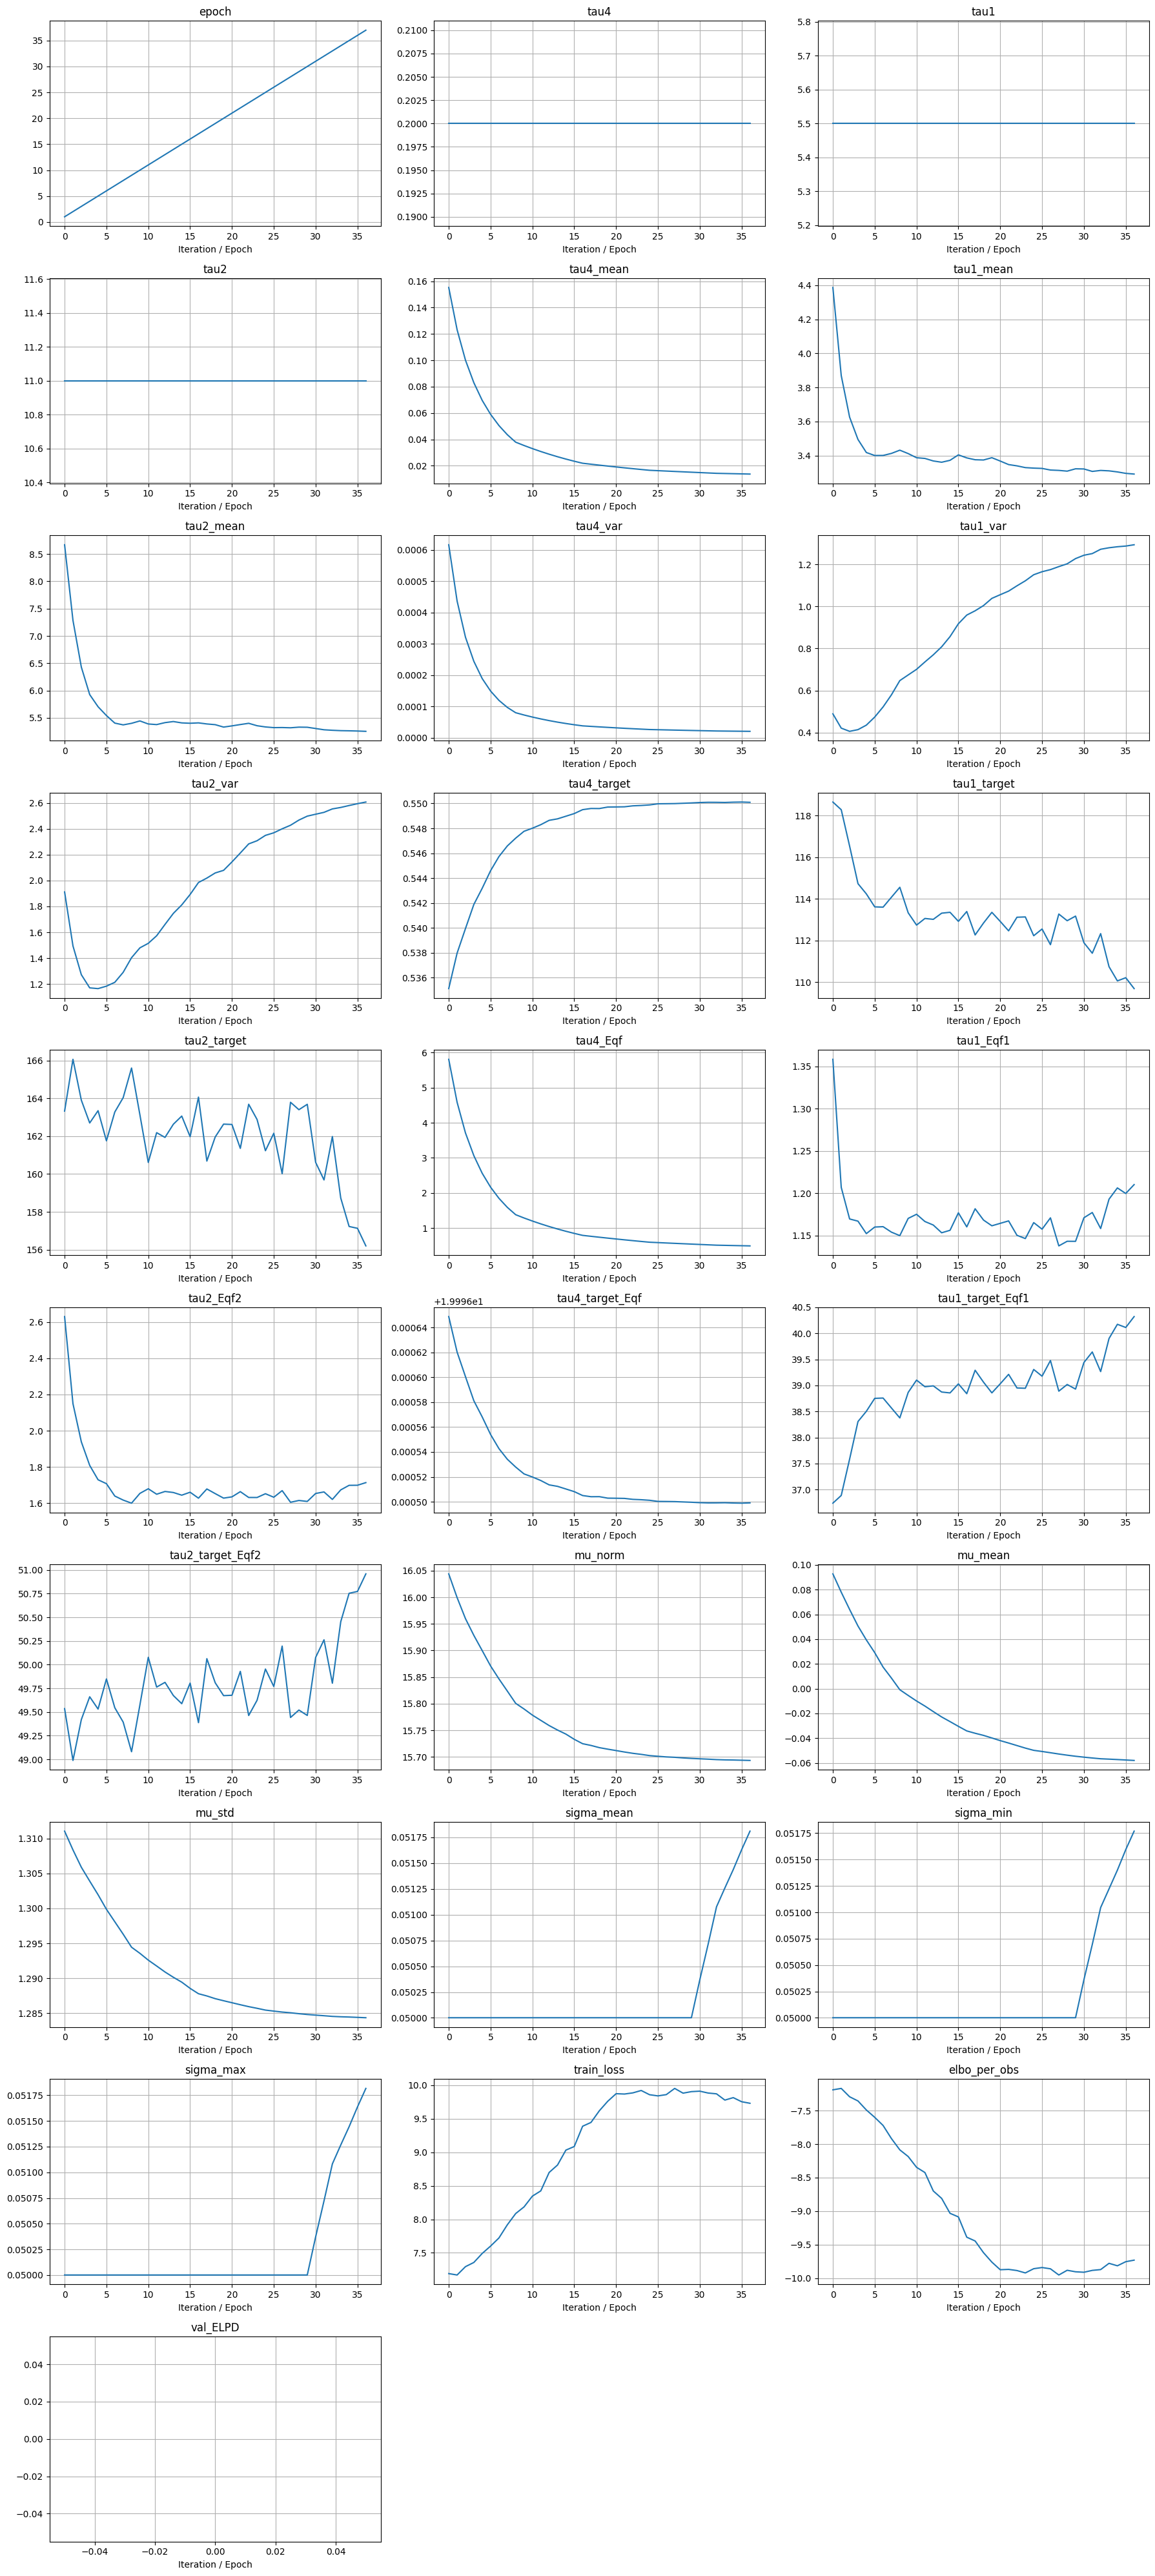

In [23]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

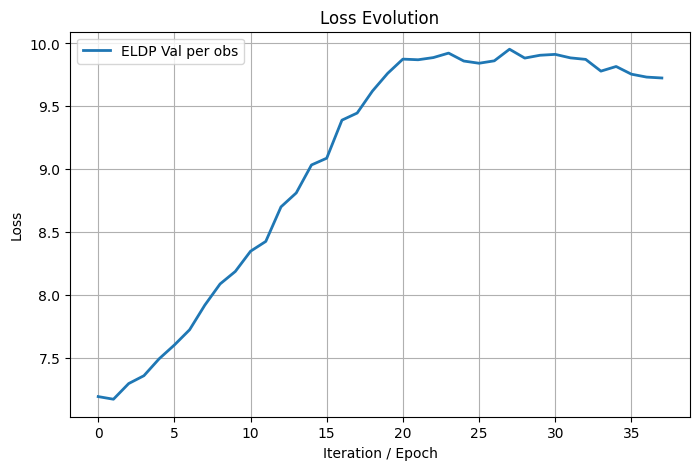

In [24]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [25]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [26]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [27]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM       Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian  Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula    Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM       Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian  Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula    Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0413
KLD GTM       Train Data:  0.0217
KLD Gaussian  Train Data:  0.0221
KLD Copula    Train Data:  0.3654

KLD BGTM      Test  Data:  0.0498
KLD GTM       Test  Data:  0.0368
KLD Gaussian  Test  Data:  0.0345
KLD Copula    Test  Data:  0.3729


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [28]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

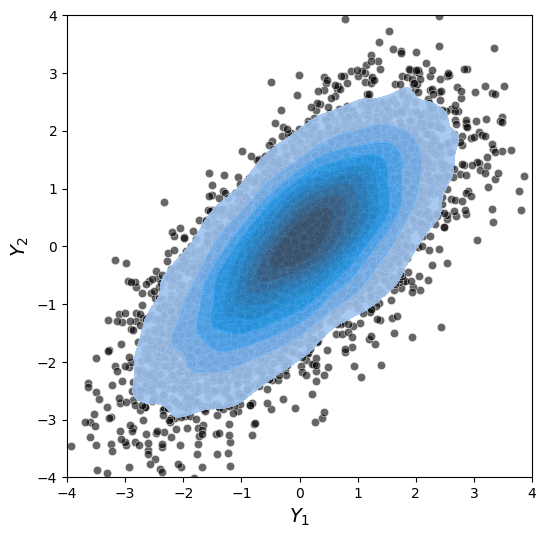

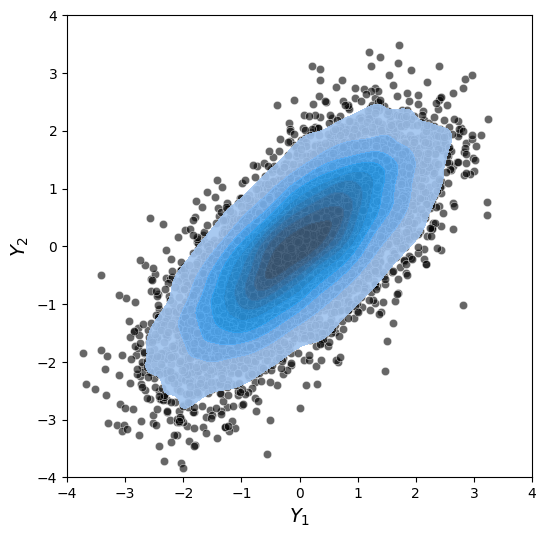

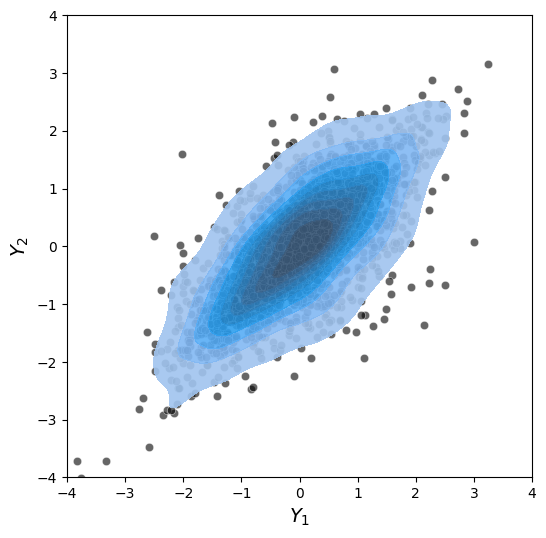

In [29]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [19]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [20]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


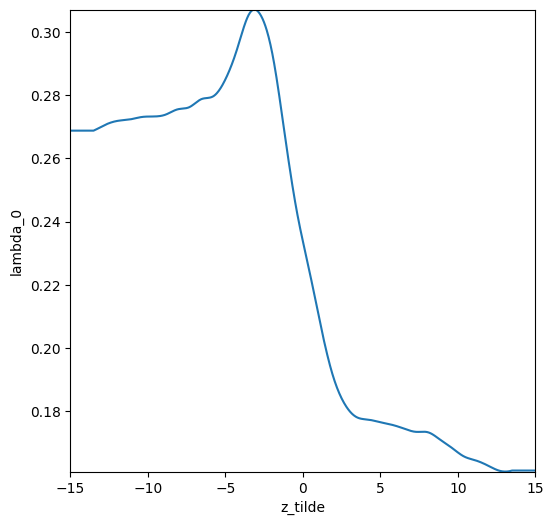

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


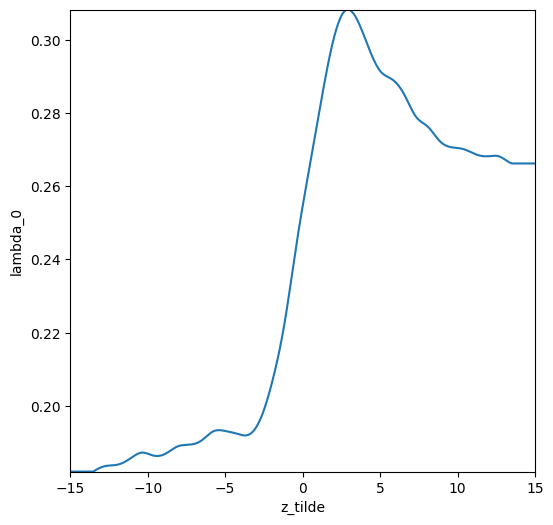

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


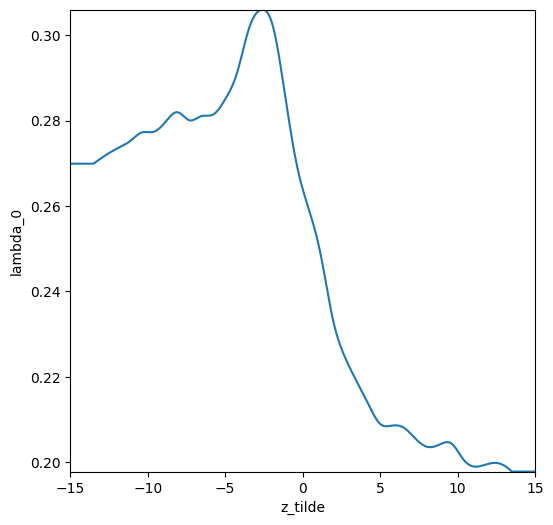

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)